## Random Forest Model

We will use the supervised learning algorithm Random Forest, as it includes a bagging method which should help deal with the imbalanced classes we have for our predicted variable. Bagging is a form of bootstrapping where it aggregates all different bootstrapped sub-samples to make a more accurate prediction compared to that of an individual model. In addition to this, Random Forest models allow us to determine feature importance and aid in feature selection for our future models. There have been studies to test the effectiveness of feature selection, and we will be basing our decision to use the Random Forest for feature selection based on a study by Chen, et. al (2020). They found the Random Forest algorithm to be the best at handling feature selection with a high number of variables in comparison to the Boruta and Recursive Feature Elimination (RFE) methods of feature selection. 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

%matplotlib inline

In [2]:
#Read in dataframe with cleaned loan data
df = pd.read_csv('./data/loan_all.csv')

In [3]:
#Creating lists of numeric and categorical columns
drop_categorical = ['emp_length', 'home_ownership', 'purpose']
numeric_col = []

for c in df.columns:
    if c not in drop_categorical:
        numeric_col.append(c)
        
numeric_col.remove('loan_status')
numeric_col.remove('term')

#### Setting Up Data

In [6]:
X = pd.get_dummies(df.drop(columns = ['loan_status']))
y = df['loan_status']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size= 0.2)

In [8]:
ss = StandardScaler()
X_train[numeric_col] = ss.fit_transform(X_train[numeric_col])
X_test[numeric_col] = ss.transform(X_test[numeric_col])

C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### Default Random Forest Model

In [37]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

In [39]:
cross_val_score(rf, X_train, y_train, cv = 5).mean()

0.9064292813806232

In [40]:
cross_val_score(rf, X_test, y_test, cv = 5).mean()

0.905025345601624

In [62]:
y_hat = rf.predict_proba(X_test)
rf_model_probs = y_hat[:,1]

In [15]:
def plot_roc_curve(test, model_probs, naive_probs):
    fpr, tpr, _ = roc_curve(test, naive_probs)
    plt.plot(fpr, tpr, linestyle = '--', label = 'No Skill')
    fpr, tpr, _ = roc_curve(test, model_probs)
    plt.plot(fpr, tpr, marker = '.', label = 'Random Forest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    

In [16]:
def plot_pr_curve(test, model_probs):
    no_skill = len(test[test == 1]) / len(test)
    
    plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
    
    precision, recall, _ = precision_recall_curve(list(test), model_probs)
    plt.plot(recall, precision, marker = '.', label = 'Random Forest')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [18]:
%time
dummy_model = DummyClassifier(strategy= 'stratified')
dummy_model.fit(X_train, y_train)
naive_preds = dummy_model.predict(X_test)


Wall time: 0 ns


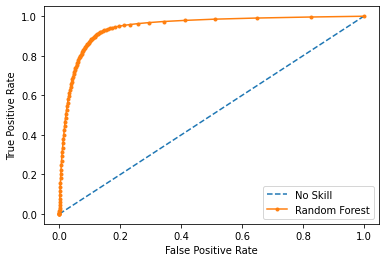

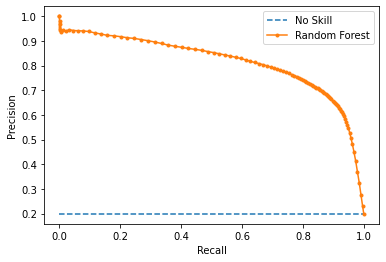

ROC-AUC score no skill: 0.500
ROC-AUC score random forest: 0.946
PR-AUC score no skill: 0.278
PR-AUC score random forest: 0.815


In [120]:
plot_roc_curve(y_test, rf_model_probs, naive_preds)
plot_pr_curve(y_test, rf_model_probs)
print(f'ROC-AUC score no skill: {roc_auc_score(y_test, naive_preds):.3f}')
print(f'ROC-AUC score random forest: {roc_auc_score(y_test, rf_model_probs):.3f}')
precision, recall, _ = precision_recall_curve(y_test, naive_preds)
print(f'PR-AUC score no skill: {auc(recall, precision):.3f}')
precision, recall, _ = precision_recall_curve(y_test, rf_model_probs)
print(f'PR-AUC score random forest: {auc(recall, precision):.3f}')

In [57]:
important_features = pd.DataFrame({'importance': rf.feature_importances_}, index = X_train.columns).sort_values(by = 'importance', ascending = False)

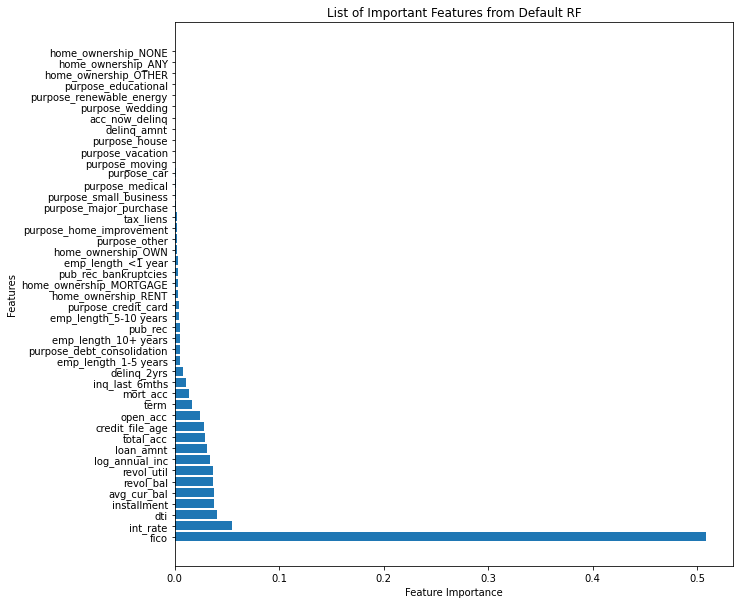

In [124]:
plt.figure(figsize = (10,10))
plt.barh(important_features.index, important_features.importance)
plt.title('List of Important Features from Default RF');
plt.xlabel('Feature Importance')
plt.ylabel('Features');

With our initial Random Forest model using default parameters, our accuracy score for both the training set and testing set performed better than the accuracy score. When looking at the feature importances, we can see that the top 5 features in importance are FICO, Interest Rate, Debt-to-Income ratio, average current balance, and revolving balance. We also see that a lot of the one-hot encoded variables show very little importance, specifically the values for home ownership that are low ('NONE', 'ANY', 'OTHER'), and the values for loan purpose that are also low. We may consider either removing these observations or grouping them into a category that almagamates them all. We also see that 'delinq_amt' and 'acc_now_delinq' also score very low in feature importance so we may drop these features for the other models. 

For now, we will utilize GridSearchCV to find the optimal parameters for our random forest model and see if we come out with the same feature importances. We will then run a model with a reduced set of features which we will regard as RF + RF.

#### Random Forest with Grid Search for Parameter Tuning

In [9]:
%time
rf = RandomForestClassifier()

rf_param_grid = {
    'n_estimators' : [50, 100, 250],
    'max_features' : ['auto', 2, 10],
    'max_depth'    : [None, 1, 3, 5, 20],
    'bootstrap'    : [True, False]
}

rf_gs = GridSearchCV(rf, param_grid=rf_param_grid, cv = 3, verbose = 2)

rf_gs.fit(X_train, y_train)
print(rf_gs.best_score_)


Wall time: 0 ns
Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=50; total time= 1.6min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=50; total time= 1.5min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=50; total time= 1.6min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=100; total time= 3.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=250; total time= 7.8min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=250; total time= 7.8min
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=250; total time= 8.6min
[CV] END bootstrap=True, max_depth=None, max_feature

AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [11]:
rf_gs.score(X_train, y_train)

0.9601850308068904

In [10]:
rf_gs.score(X_test, y_test)

0.9067949466089685

In [20]:
gs_y_hat = rf_gs.predict_proba(X_test)
gs_train_preds = rf_gs.predict_proba(X_train)

In [21]:
gs_model_probs = gs_y_hat[:,1]
gs_model_train_probs = gs_train_preds[:,1]

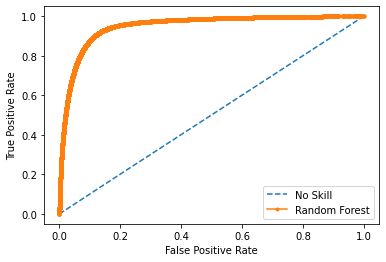

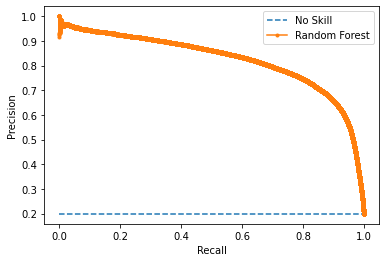

Training Data ROC-AUC score random forest (GridSearch CV): 0.992
Testing Data ROC-AUC score random forest (GridSearch CV): 0.950
Training Data PR-AUC score random forest (GridSearch CV): 0.971
Testing Data PR-AUC score random forest (GridSearch CV): 0.824


In [22]:
plot_roc_curve(y_test, gs_model_probs, naive_preds)
plot_pr_curve(y_test, gs_model_probs)
print(f'Training Data ROC-AUC score random forest (GridSearch CV): {roc_auc_score(y_train, gs_model_train_probs):.3f}')
print(f'Testing Data ROC-AUC score random forest (GridSearch CV): {roc_auc_score(y_test, gs_model_probs):.3f}')
precision, recall, _ = precision_recall_curve(y_train, gs_model_train_probs)
print(f'Training Data PR-AUC score random forest (GridSearch CV): {auc(recall, precision):.3f}')
precision, recall, _ = precision_recall_curve(y_test, gs_model_probs)
print(f'Testing Data PR-AUC score random forest (GridSearch CV): {auc(recall, precision):.3f}')

In [23]:
rf_gs.best_params_

{'bootstrap': True, 'max_depth': 20, 'max_features': 10, 'n_estimators': 250}

In [ ]:
#From our default model
ROC-AUC score no skill: 0.500
ROC-AUC score random forest: 0.946
PR-AUC score no skill: 0.278
PR-AUC score random forest: 0.815

#### Evaluating Grid Search

We can see that with parameters tuned, there is a 0.42% increase in the ROC-AUC score as well as a 1.1% increase in the PR-AUC score. 

In [39]:
df.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,...,revol_util,acc_now_delinq,avg_cur_bal,delinq_amnt,pub_rec_bankruptcies,tax_liens,mort_acc,credit_file_age,fico,log_annual_inc
0,3600.0,0,13.99,123.03,10+ years,MORTGAGE,0,debt_consolidation,5.91,0.0,...,29.7,0.0,20701.0,0.0,0.0,0.0,1.0,12,562.0,10.915088
1,24700.0,0,11.99,820.28,10+ years,MORTGAGE,0,small_business,16.06,1.0,...,19.2,0.0,9733.0,0.0,0.0,0.0,4.0,16,697.0,11.082143
2,10400.0,1,22.45,289.91,1-5 years,MORTGAGE,0,major_purchase,25.37,1.0,...,64.5,0.0,27644.0,0.0,0.0,0.0,6.0,17,702.0,11.556301
3,11950.0,0,13.44,405.18,1-5 years,RENT,0,debt_consolidation,10.20,0.0,...,68.4,0.0,2560.0,0.0,0.0,0.0,0.0,28,757.0,10.434116
4,20000.0,0,9.17,637.58,10+ years,MORTGAGE,0,debt_consolidation,14.67,0.0,...,84.5,0.0,30030.0,0.0,0.0,0.0,4.0,25,652.0,12.100712


#### Random Forest with Feature Selection and Best Parameters

In [ ]:
df.drop(columns = ['acc_now_delinq', 'delinq_amnt'], inplace = True)

In [ ]:
df.head()